In [68]:
import scipy.io
import numpy as np
import pylab as pl

In [69]:
mat = scipy.io.loadmat('data/binaryalphadigs.mat')
data_digits = mat['dat'][:10,]
data_alpha = mat['dat'][10:,]
print("data_digits shape = {}".format(data_digits.shape))
print("data_alpha shape = {}".format(data_alpha.shape))

data_digits shape = (10, 39)
data_alpha shape = (26, 39)


In [70]:
def lire_alpha_digits(data, list_index):
    m, n = data.shape
    p, q = data[0, 0].shape
    matrix = np.zeros((len(list_index)*n, p*q))
    for i, index in enumerate(list_index):
        for j in range(n):
            matrix[i*n + j] = data[index, j].reshape(p*q)
    return matrix

In [71]:
Xa = lire_alpha_digits(data_alpha, [0])
Xb = lire_alpha_digits(data_alpha, [1])
Xc = lire_alpha_digits(data_alpha, [2])
# data_digits_reshaped = lire_alpha_digits(data_digits, [0])

In [72]:
class DnnModel():
    def __init__(self, d: int, p: int, q: int, n_classes: int) -> None:
        """
        Initialise une instance de la classe DnnModel.

        Args:
            d (int): Nombre de couches dans le DNN.
            p (int): Dimension de la couche d'entrée.
            q (int): Dimension de la couche cachée.
            n_classes (int): Nombre de classes pour la classification.
        """
        self.d = d
        self.q = q
        self.p = p
        self.n_classes = n_classes
        self.A = np.zeros((d-1, q))
        self.B = np.zeros((d-1, q))
        self.W = np.random.normal(0, 0.1, size=(d-1, q, q))
        self.W0 = np.random.normal(0, 0.1, size=(p, q))
        self.a0 = np.zeros(p)
        self.b0 = np.zeros(q)
        # Classification
        self.Wc = np.random.normal(0, 0.1, size=(q, n_classes))
        self.bc = np.zeros(n_classes)
    
    def entree_sortie_RBM(self, d: int, H: np.ndarray) -> np.ndarray:
        """
        Calcule l'activation d'une couche d'un RBM. (dir. latente -> visible)

        Args:
            d (int): Indice de la couche RBM.
            H (np.ndarray): Matrice des activations de la couche précédente (d-1).
        """
        if d != 0:
            A = np.tile(self.A[d-1, :], (H.shape[0], 1))
            Z = np.transpose(self.W[d-1, :, :] @ H.T) + A
            return np.exp(Z)/(1 + np.exp(Z))
        else:
            A = np.tile(self.a0, (H.shape[0], 1))
            Z = np.transpose(self.W0 @ H.T) + A
            return np.exp(Z)/(1 + np.exp(Z))

    def sortie_entree_RBM(self, d: int, V: np.ndarray) -> np.ndarray:
        """
        Calcule l'activation d'une couche d'un RBM. (dir. visible -> latente)

        Args:
            d (int): Indice de la couche RBM.
            H (np.ndarray): Matrice des activations de la couche précédente (d-1).
        """
        if d != 0:
            B = np.tile(self.B[d-1, :], (V.shape[0], 1))
            Z = np.transpose(self.W[d-1, :, :].T @ V.T) + B
            return np.exp(Z)/(1 + np.exp(Z))
        else:
            B = np.tile(self.b0, (V.shape[0], 1))
            Z = np.transpose(self.W0.T @ V.T) + B
            return np.exp(Z)/(1 + np.exp(Z))

    def entree_sortie_DBN(self, H: np.ndarray) -> np.ndarray:
        """
        Calcule l'activation de la couche visible d'un Deep Belief Network (DBN)
        en utilisant les données de la couche latente.

        Args:
            H (np.ndarray): Matrice des activations de la couche cachée.

        Returns:
            np.ndarray: Activation de la couche visible.
        """
        rng = np.random.default_rng()
        E = H.copy()
        for t in range(1, self.d + 1):
            Pe = self.entree_sortie_RBM(self.d - t, E)
            E = rng.binomial(1, Pe, size=Pe.shape)
        return E

    def sortie_entree_DBN(self, V: np.ndarray) -> np.ndarray:
        """
        Calcule l'activation de la couche latente d'un Deep Belief Network (DBN)
        en utilisant les données de la couche visible.

        Args:
            V (np.ndarray): Matrice des activations de la couche cachée.

        Returns:
            np.ndarray: Activation de la couche latente.
        """
        rng = np.random.default_rng()
        S = V.copy()
        for t in range(self.d):
            Ps = self.sortie_entree_RBM(t, S)
            S = rng.binomial(1, Ps, size=Ps.shape)
        return S
    
    def classif_DNN(self, V: np.ndarray) -> tuple([np.ndarray, np.ndarray]):
        """
        Effectue la classification en utilisant les activations de la couche cachée du DNN.

        Args:
            V (np.ndarray): Matrice des activations de la dernière couche cachée.

        Returns:
            Tuple[np.ndarray, np.ndarray]: Valeurs et probabilités après softmax de la classification.
        """
        S = V.copy()
        B = np.tile(self.bc, (V.shape[0], 1))
        Z = S @ self.Wc + B
        # Values
        # Values = np.exp(Z)/(1 + np.exp(Z))
        # Probas
        vector_sum = np.sum(np.exp(Z), axis=1)
        matrix_sum = np.tile(vector_sum, (Z.shape[1], 1)).T
        Probas = np.exp(Z) / matrix_sum
        return Z, Probas

    def split_in_batches(self, indexes: np.ndarray, batch: int) -> list([np.ndarray]):
        """
        Divise une liste d'indices en lots de la taille spécifiée.

        Args:
            indexes (np.ndarray): Liste des indices à diviser en lots.
            batch (int): Taille de chaque lot.

        Returns:
            List[np.ndarray]: Liste des lots d'indices.
        """
        Batches = []
        N = len(indexes) // batch
        for i in range(N):
            Batches.append(indexes[i*batch:i*batch+batch])
        Batches.append(indexes[N*batch:len(indexes)])
        return Batches

    def train_RBM(self, t: int, X: np.ndarray, niter: int, step: float, batch: int, verbose: bool=True) -> None:
        """
        Entraîne une couche RBM du réseau en utilisant la rétro-propagation contrastive (CD-k).

        Args:
            t (int): Indice de la couche RBM à entraîner.
            X (np.ndarray): Données d'entraînement.
            niter (int): Nombre d'itérations d'entraînement.
            step (float): Taux d'apprentissage pour la mise à jour des poids.
            batch (int): Taille de lot pour l'entraînement par lot.
            verbose (bool): Afficher ou non les détails de l'entraînement.
        """
        if t != 0:
            assert X.shape[1] == self.W[t-1, :, :].shape[0], (
                'Dimention of input incompatible with parameters of RBM')
        else:
            assert X.shape[1] == self.W0.shape[0], (
                'Dimention of input incompatible with parameters of RBM')
        batches_index = self.split_in_batches(np.arange(X.shape[0]), batch)
        rng = np.random.default_rng()
        for epoch in range(niter):
            loss = 0
            for batch in batches_index:
                X_batch = X[batch]
                N = X_batch.shape[0]
                Ph = self.sortie_entree_RBM(t, X_batch)
                H = rng.binomial(1, Ph, size=(N, Ph.shape[1]))
                Pv = self.entree_sortie_RBM(t, H)
                V = rng.binomial(1, Pv, size=(N, Pv.shape[1]))
                Mh = self.sortie_entree_RBM(t, V)
                loss += np.sum((V - X_batch)**2)

                # Compute the gradients
                grad_W = X_batch.T @ Ph - V.T @ Mh
                grad_a = np.sum(X_batch - V, axis=0)
                grad_b = np.sum(Ph - Mh, axis=0)

                # Update the parameters
                if t != 0:
                    self.W[t-1, :, :] += step*grad_W
                    self.A[t-1, :] += step*grad_a
                    self.B[t-1, :] += step*grad_b
                else:
                    self.W0 += step*grad_W
                    self.a0 += step*grad_a
                    self.b0 += step*grad_b
            loss /= X.shape[0]
            if verbose:
                print("Epoch {}/{} : MSE = {}".format(epoch + 1, niter, loss))

    def pretrain_DNN(self, X: np.ndarray, niter: int, step: float, batch: int, verbose: bool=True) -> None:
        """
        Pré-entraîne les RBM du DNN en cascade avec les données d'entrée spécifiées.

        Args:
            X (np.ndarray): Données d'entrée pour l'entraînement préalable.
            niter (int): Nombre d'itérations d'entraînement par RBM.
            step (float): Taux d'apprentissage.
            batch (int): Taille de lot pour l'entraînement par lot.
            verbose (bool): Afficher ou non les détails de l'entraînement.
        """
        S = X.copy()
        rng = np.random.default_rng()
        for t in range(self.d):
            self.train_RBM(t, S, niter, step, batch, verbose=False)
            Ps = self.sortie_entree_RBM(t, S)  # CHANGE HERE
            S = rng.binomial(1, Ps, size=(X.shape[0], self.q))
            if verbose:
                print('Training Layer {}/{} ...'.format(t+1, self.d))
    
    def generer_image_DBN(self, n_images: int, n_iter: int) -> np.ndarray:
        """
        Génère des images en utilisant le Deep Belief Network (DBN).

        Args:
            n_images (int): Nombre d'images à générer.
            n_iter (int): Nombre d'itérations pour la génération.

        Returns:
            np.ndarray: Matrice des images générées.
        """
        X = np.random.binomial(1, 0.5, size=(n_images, self.q))
        E = X.copy()
        rng = np.random.default_rng()
        for _ in range(n_iter):
            Pv = self.entree_sortie_DBN(E)
            V = rng.binomial(1, Pv, size=(n_images, self.p))
            Ph = self.sortie_entree_DBN(V)
            E = rng.binomial(1, Ph, size=(n_images, self.q))
        return V
    
    def sortie_entree_RBM_retro(self, d: int, V: np.ndarray) -> tuple([np.ndarray, np.ndarray]):
        """
        Calcule l'activation de la couche cachée en fonction de l'activation de la couche visible
        pour une couche RBM spécifique (utilisé lors de la rétro-propagation).

        Args:
            d (int): Indice de la couche RBM.
            V (np.ndarray): Matrice des activations de la couche visible.

        Returns:
            Tuple[np.ndarray, np.ndarray]: Valeurs et probabilités d'activation pour la couche cachée.
        """
        if d != 0:
            # print(self.W[d-1, :, :].T.shape)
            # print(V.T.shape)
            B = np.tile(self.B[d-1, :], (V.shape[0], 1))
            Z = np.transpose(self.W[d-1, :, :].T @ V.T) + B
            return Z, np.exp(Z)/(1 + np.exp(Z))
        else:
            B = np.tile(self.b0, (V.shape[0], 1))
            Z = np.transpose(self.W0.T @ V.T) + B
            return Z, np.exp(Z)/(1 + np.exp(Z))
    
    def entree_sortie_reseau(self, X: np.ndarray) -> tuple([list([np.ndarray]), list([np.ndarray])]):
        """
        Effectue la propagation avant à travers le réseau et retourne les valeurs
        et probabilités d'activation pour chaque couche.

        Args:
            X (np.ndarray): Données d'entrée.

        Returns:
            Tuple[List[np.ndarray], List[np.ndarray]]: Valeurs et probabilités d'activation pour chaque couche.
        """
        Values = []
        Probas = []
        A = X.copy()
        for t in range(self.d):
            Z, A = self.sortie_entree_RBM_retro(t, A)
            Values.append(Z)
            Probas.append(A)
        S, P = self.classif_DNN(A)
        Values.append(S)
        Probas.append(P)
        return Values, Probas
    
    def retropropagation(self, X: np.ndarray, y: np.ndarray, epsilon: float) -> None:
        """
        Effectue la rétro-propagation à travers le réseau pour ajuster les poids.

        Args:
            X (np.ndarray): Données d'entrée pour la rétro-propagation.
            y (np.ndarray): Étiquettes de classe correspondantes.
            epsilon (float): Taux d'apprentissage pour la mise à jour des poids.
        """
        N = X.shape[0]
        # One hot encoding of y
        Y = np.eye(self.n_classes)[y]
        # Forward pass
        Values, Probas = self.entree_sortie_reseau(X)
        # Backward pass sur couche de classification
        # print('Training classif...')
        A2 = Probas[-1].copy()
        A1 = Values[-2].copy()
        grad_Lz = A2 - Y
        grad_LW = 1/N * A1.T @ grad_Lz
        grad_Lb = grad_Lz.mean(axis=0)
        grad_La2 = grad_Lz @ self.Wc.T
        self.Wc -= epsilon * grad_LW
        self.bc -= epsilon * grad_Lb
        # Backward pass sur le DBN
        # print('Classif trained')
        for d in range(2, self.d + 1):
            # print('layer number {} '.format(d))
            A2 = Probas[-d].copy()
            A1 = Probas[-(d+1)].copy()
            # print('Shapes A1, A2 = {}, {}'.format(A1.shape, A2.shape))
            sig_p = np.multiply(A2, 1-A2)
            grad_Lz = np.multiply(grad_La2, sig_p)
            grad_LW = 1/N * A1.T @ grad_Lz
            grad_Lb = grad_Lz.mean(axis=0)
            grad_La2 = grad_Lz @ self.W[-(d-1), :, :].T
            if d == self.d + 1:
                self.W0 -= epsilon * grad_LW
                self.b0 -= epsilon * grad_Lb
            else:
                # print(d)
                # print('Grad_LW.shape = {}'.format(grad_LW.shape))
                self.W[-(d-1), :, :] -= epsilon * grad_LW
                self.B[-(d-1), :] -= epsilon * grad_Lb
    
    def train_DNN(self, X: np.ndarray, y: np.ndarray, n_epochs: int, epsilon: float, batch: int, verbose: bool=True) -> None:
        """
        Entraîne le DNN en utilisant la rétro-propagation.

        Args:
            X (np.ndarray): Données d'entraînement.
            y (np.ndarray): Étiquettes de classe correspondantes.
            n_epochs (int): Nombre d'époques d'entraînement.
            epsilon (float): Taux d'apprentissage pour la mise à jour des poids.
            batch (int): Taille de lot pour l'entraînement par lot.
            verbose (bool): Afficher ou non les détails de l'entraînement.
        """
        batches_index = self.split_in_batches(np.arange(X.shape[0]), batch)
        for epoch in range(n_epochs):
            for batch in batches_index:
                X_batch = X[batch]
                y_batch = y[batch]
                self.retropropagation(X_batch, y_batch, epsilon)
            if verbose:
                score = np.mean(self.predict(X)==y)
                print('Epoch {}/{} : Accuracy score = {}'.format(epoch, n_epochs, score)) 
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Prédit les classes pour les données d'entrée spécifiées.

        Args:
            X (np.ndarray): Données d'entrée pour les prédictions.

        Returns:
            np.ndarray: Prédictions de classe.
        """
        _, probas = self.entree_sortie_reseau(X)
        y_hat = probas[-1]
        return np.argmax(y_hat, axis=1)
    
    def predict_score(self, X: np.ndarray, y: np.ndarray) -> float:
        """
        Calcule le score d'accuracy pour les données d'entrée spécifiées.

        Args:
            X (np.ndarray): Données d'entrée pour évaluer les prédictions.
            y (np.ndarray): Étiquettes de classe correspondantes.

        Returns:
            float: Score de précision.
        """
        y_hat = self.predict(X)
        return np.mean(y==y_hat)

In [73]:
Xab = np.concatenate((Xa, Xb))
Xac = np.concatenate((Xa, Xc))
Xabc = np.concatenate((Xa, Xc, Xb))

In [74]:
dnn = DnnModel(d=3, p=320, q=150, n_classes=3)
dnn.pretrain_DNN(X=Xa, niter=150, step=0.01, batch=10)
dnn.pretrain_DNN(X=Xac, niter=150, step=0.01, batch=10)
dnn.pretrain_DNN(X=Xabc, niter=150, step=0.01, batch=10)

Training Layer 1/3 ...
Training Layer 2/3 ...
Training Layer 3/3 ...
Training Layer 1/3 ...
Training Layer 2/3 ...
Training Layer 3/3 ...
Training Layer 1/3 ...
Training Layer 2/3 ...
Training Layer 3/3 ...


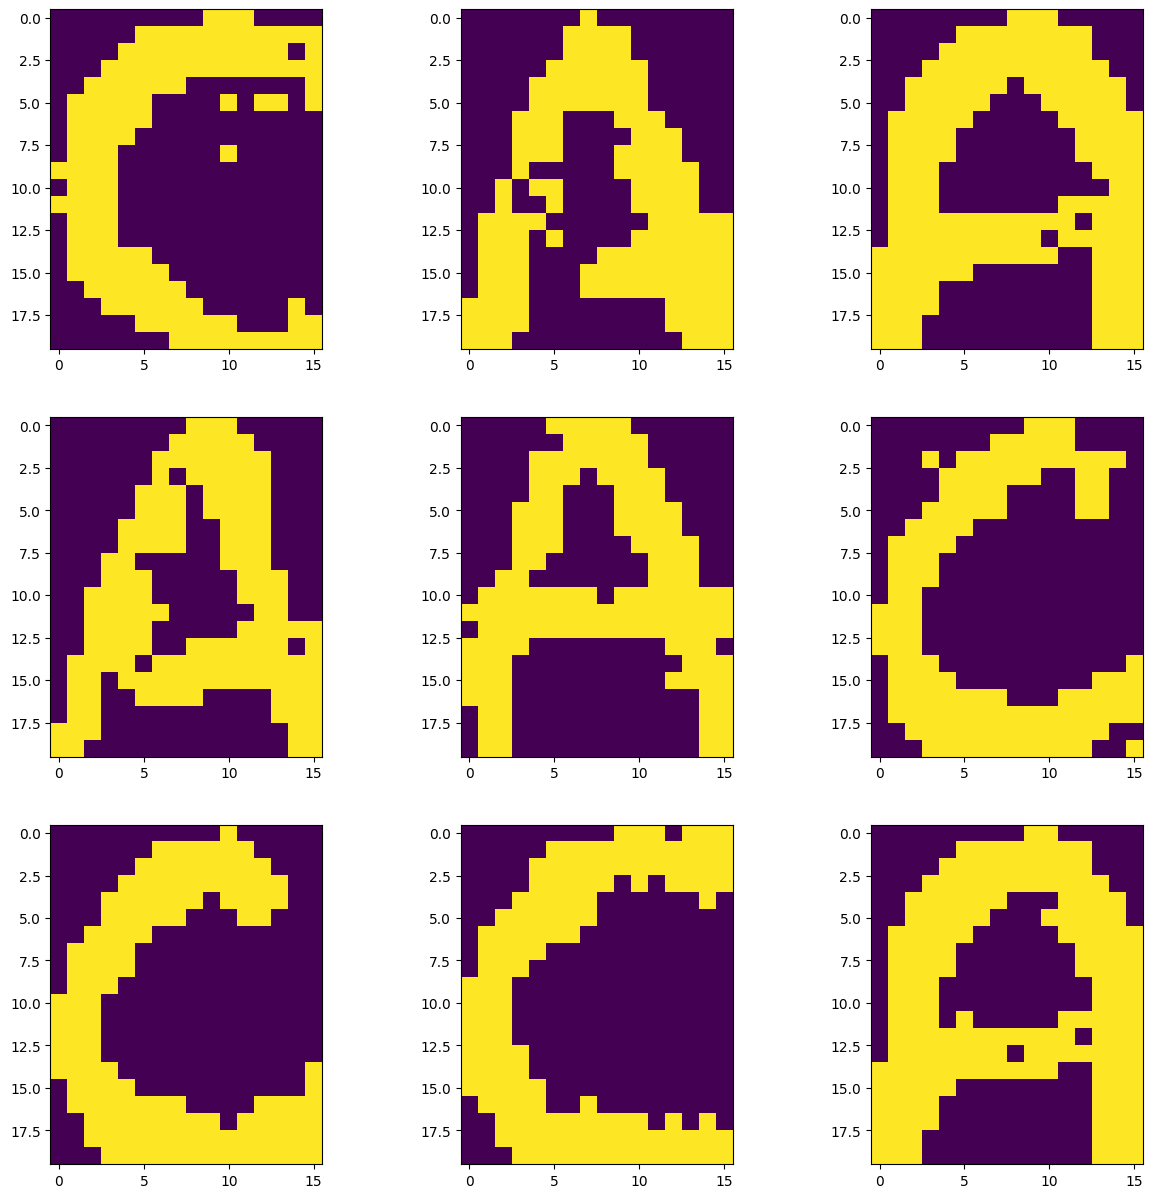

In [75]:
gen = dnn.generer_image_DBN(9, 10)

fig, ax = pl.subplots(3, 3, figsize=(15, 15))

for i in range(3):
    for j in range(3):
        ax[i, j].imshow(gen[3*i + j,:].reshape(20, 16))

In [76]:
Xabc = np.concatenate((Xa, Xb, Xc))

In [77]:
y = np.concatenate((np.zeros(39), np.ones(39), 2*np.ones(39))).astype(int)

In [78]:
dnn.train_DNN(Xabc, y, n_epochs=50, epsilon=0.01, batch=10, verbose=True)

Epoch 0/50 : Accuracy score = 0.7435897435897436
Epoch 1/50 : Accuracy score = 0.7264957264957265
Epoch 2/50 : Accuracy score = 0.7350427350427351
Epoch 3/50 : Accuracy score = 0.7350427350427351
Epoch 4/50 : Accuracy score = 0.7435897435897436
Epoch 5/50 : Accuracy score = 0.7435897435897436
Epoch 6/50 : Accuracy score = 0.7435897435897436
Epoch 7/50 : Accuracy score = 0.7435897435897436
Epoch 8/50 : Accuracy score = 0.7435897435897436
Epoch 9/50 : Accuracy score = 0.7350427350427351
Epoch 10/50 : Accuracy score = 0.7350427350427351
Epoch 11/50 : Accuracy score = 0.7435897435897436
Epoch 12/50 : Accuracy score = 0.7435897435897436
Epoch 13/50 : Accuracy score = 0.7521367521367521
Epoch 14/50 : Accuracy score = 0.7606837606837606
Epoch 15/50 : Accuracy score = 0.7692307692307693
Epoch 16/50 : Accuracy score = 0.7777777777777778
Epoch 17/50 : Accuracy score = 0.7777777777777778
Epoch 18/50 : Accuracy score = 0.7777777777777778
Epoch 19/50 : Accuracy score = 0.7863247863247863
Epoch 20/5

In [79]:
y_hat = dnn.predict(Xabc)

In [80]:
np.mean(y==y_hat)

0.9743589743589743

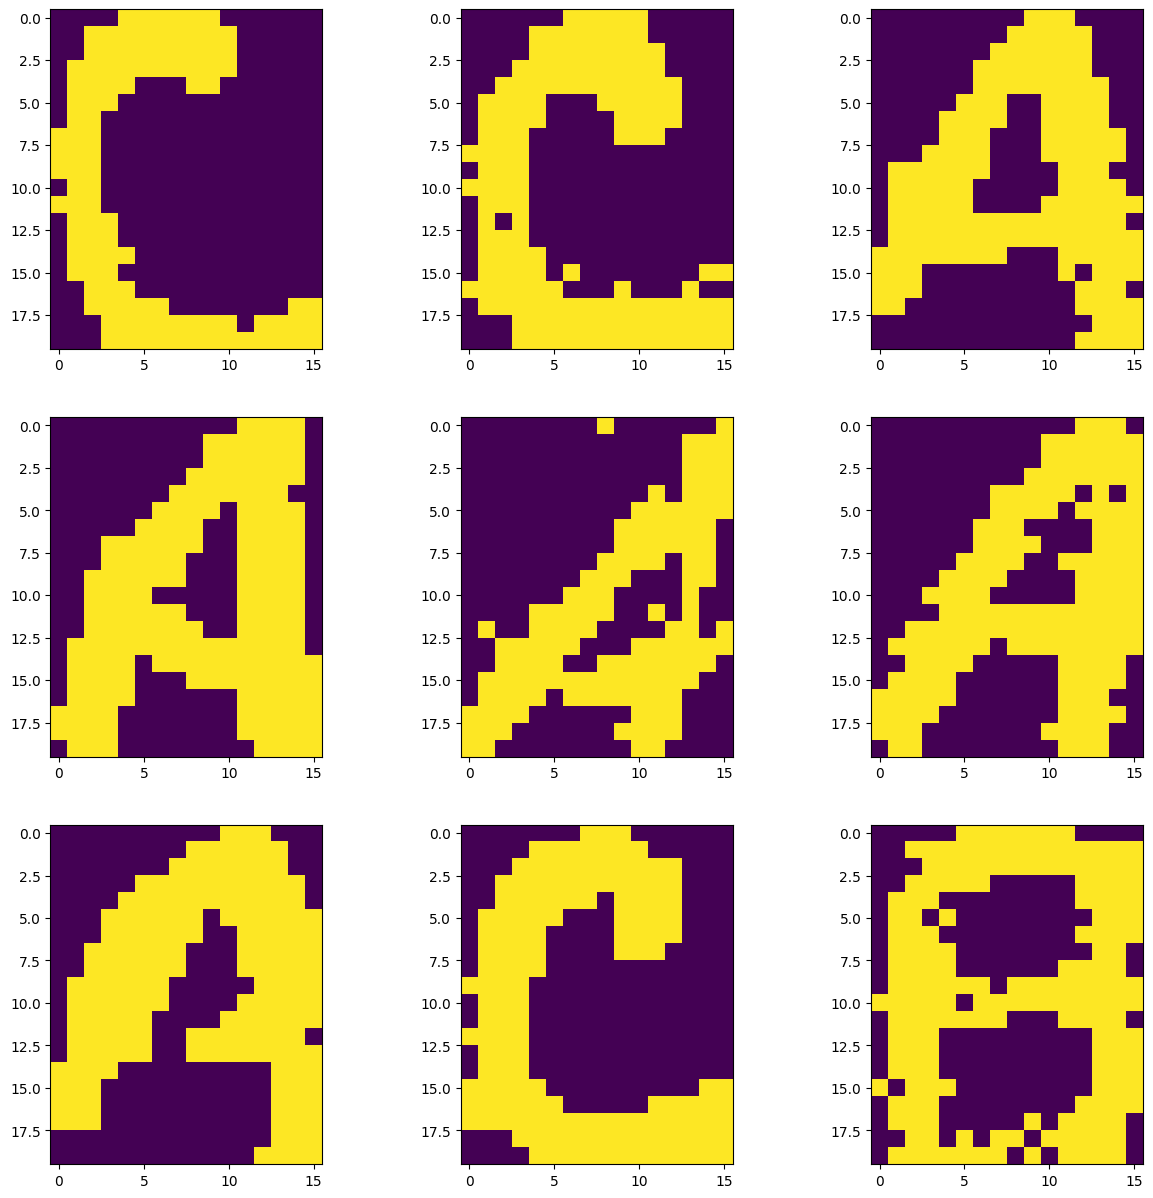

In [81]:
gen = dnn.generer_image_DBN(9, 10)

fig, ax = pl.subplots(3, 3, figsize=(15, 15))

for i in range(3):
    for j in range(3):
        ax[i, j].imshow(gen[3*i + j,:].reshape(20, 16))